In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.26.1
    Uninstalling starlette-0.26.1:
      Successfully uninstalled starlette-0.26.1
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.95.0
    Uninstalling fastapi-0.95.0:
      Successfully uninstalled fastapi-0.95.0


In [2]:
!pip install transformers

In [3]:
!pip install torchmetrics

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchtext
import numpy as np
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from torchmetrics import Accuracy, F1Score
import torchmetrics
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# utils

In [5]:
class EmpathyConversationDataset(Dataset):
    

    FILE_PATH = {'train': "/kaggle/input/dialogue-empathy-detection/train.csv",
                 'test': "/kaggle/input/dialogue-empathy-detection/test.csv",
                 'val': "/kaggle/input/dialogue-empathy-detection/val.csv",}

    def __init__(self, split="train", transforms=None):

        if split.lower() not in self.FILE_PATH.keys():
            raise Exception("must be train or test or val")

        df = pd.read_csv(self.FILE_PATH[split.lower()])
        df = self.conv_preprocess(df)
        
        self.x = df[['utterance']].to_numpy()
        self.y = df[['empathy']].to_numpy()
        self.n_sample = len(df)

        self.transforms = transforms
    
    def conv_preprocess(self, df):
        return df.groupby('conv_id')['utterance'].apply(list).reset_index().\
                  merge(df.groupby('conv_id')['empathy'].max().reset_index(), on='conv_id', how="inner")

    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        return self._pipline_transforms(sample)
    
    def _pipline_transforms(self, sample):
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
        return sample
    
    def __len__(self):
        return self.n_sample

In [6]:
class TextListCleaner:

    punc = '''!()-[]{.};:'"\,<>/?@#$%^&*_~`|’“”…—–'''

    def __call__(self, sample):
        texts, target = sample
        texts = texts[0]
        new_texts = list()
        
        for text in texts:
            text = text.lower()
            for each in self.punc:
                text = text.replace(each, ' ')
            new_texts.append(text)
        return np.array([new_texts]), target


class ConversationFormater:
    SPECIAL_TOKEN_START_UTTERANCE = "<BOU>"
    SPECIAL_TOKEN_END_UTTERANCE = "<EOU>"  
    
    def __call__(self, sample):
        texts, target = sample
        texts = texts[0]
        
        conversation = str()
        for text in texts:
            conversation += f"{self.SPECIAL_TOKEN_START_UTTERANCE} {text} {self.SPECIAL_TOKEN_END_UTTERANCE} "
        return np.array([conversation]), target

    
class Tokenizer:

    def __init__(self, version="bert-base-uncased", max_len=128, tokenizer=None, new_special_tokens=None):
        self.tokenizer = AutoTokenizer.from_pretrained(version) if tokenizer is None else tokenizer
        
        if new_special_tokens:
            tokenizer.add_special_tokens(new_special_tokens)
            
        self.MAX_LEN = max_len

    def __call__(self, sample):
        text, target = sample
        inputs = self.tokenizer.encode_plus(text[0], add_special_tokens=True, max_length=self.MAX_LEN, padding='max_length', 
                                             return_attention_mask=True, return_token_type_ids=True, truncation=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], target


class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        return tuple(torch.from_numpy(np.array(each)) for each in sample)
    

class OneHotLabel:
    
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def __call__(self, sample):
        target = sample[-1]
        target = torch.squeeze(torch.nn.functional.one_hot(target, num_classes=self.num_classes), dim=0)
        sample = list(sample[:-1]) + [target]
        return tuple(sample)

In [7]:
class HistoryCallback(Callback):

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({key: value.item() for key, value in trainer.callback_metrics.items()})

# Roberta

In [8]:
from transformers import RobertaConfig
print(RobertaConfig())

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [9]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
pip_trans = [TextListCleaner(), 
             ConversationFormater(),
             Tokenizer(tokenizer=tokenizer, new_special_tokens={'additional_special_tokens': [ConversationFormater.SPECIAL_TOKEN_START_UTTERANCE,
                                                                                              ConversationFormater.SPECIAL_TOKEN_END_UTTERANCE],
                                                               'pad_token': '[PAD]'},
                        max_len=512),
             ToTensor()]

In [11]:
train_dataset = EmpathyConversationDataset(transforms=pip_trans)
test_dataset = EmpathyConversationDataset(split="test", transforms=pip_trans)
val_dataset = EmpathyConversationDataset(split="val", transforms=pip_trans)

In [12]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=16)

In [13]:
from transformers import RobertaModel


class EmpathyDetectionRobertaModel(pl.LightningModule):
    
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="binary").to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="binary").to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self, embedding_tokens_len=None):
        super().__init__()
        self.transformer_model = transformer_model=RobertaModel.from_pretrained("roberta-base")
        if embedding_tokens_len:
            # when transformer_model.wte.weight.shape[0] != len(tokenizer)
            self.transformer_model.resize_token_embeddings(embedding_tokens_len)
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [14]:
model = EmpathyDetectionRobertaModel(embedding_tokens_len=len(tokenizer))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./roberta",
    filename="roberta-empathy-conv-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type         | Params
---------------------------------------------------
0 | transformer_model | RobertaModel | 124 M 
1 | drop              | Dropout      | 0     
2 | out               | Linear       | 769   
---------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.595   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

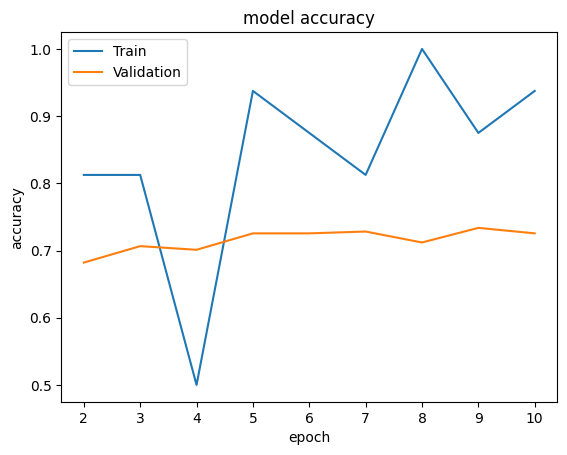

In [18]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

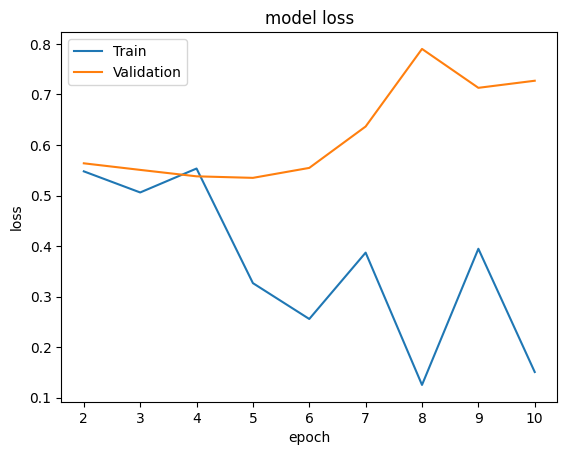

In [19]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [20]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/roberta/roberta-empathy-conv-epoch=04-val_loss=0.53.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/roberta/roberta-empathy-conv-epoch=04-val_loss=0.53.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │     0.694376528263092     │
│       test_f1_epoch       │     0.799717366695404     │
│      test_loss_epoch      │    0.5515133142471313     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.5515133142471313,
  'test_accuracy_epoch': 0.694376528263092,
  'test_f1_epoch': 0.799717366695404}]